## Drawing For each Case

In [6]:
import yfinance as yf, pandas as pd, numpy as np
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm
warnings.filterwarnings("ignore")

mu= np.array([0.038, 0.050, 0.113, 0.001])
Sigma  = np.array([[ 0.070,-0.007, 0.015, 0.003],
                   [-0.007, 0.033,-0.012, 0.001],
                   [ 0.015,-0.012, 0.098,-0.001],
                   [ 0.003, 0.001,-0.001, 0.001]])

T = 22

b = 1 + mu
a = b**T
B = (b[:,None]*b[None,:] + Sigma)
C = B**T
K = C - np.outer(a,a)           # (4,4)

## Solver Settings

In [7]:
import cvxpy as cp
solver_setting = {'solver': 'OSQP', 'max_iter': 10000}
bh_longonly = []
bh_longshort = []
rb_longonly = []
rb_longshort = []
constrained_bh_longonly = []
constrained_bh_longshort = []
constrained_rb_longonly = []
constrained_rb_longshort = []

def solvebh(mu_p, shorting=False):
    w = cp.Variable(4)
    objective = cp.quad_form(w, K)
    if shorting:
        constraints = [
            cp.sum(w) == 1,
            a @ w == mu_p,
        ]
    else:
        constraints = [
            cp.sum(w) == 1,
            w >= 0,
            a @ w == mu_p,

        ]
    prob = cp.Problem(cp.Minimize(objective), constraints)
    try:
        prob.solve(**solver_setting)
    except cp.error.SolverError:
        return None
    w_opt = w.value
    if w_opt is None:
        return None
    if shorting: bh_longshort.append(w_opt)
    else: bh_longonly.append(w_opt)
    s = np.sqrt(w_opt @ K @ w_opt)
    return s

def solve3_bh(mu_p, shorting=False):
    w = cp.Variable(4)
    objective = cp.quad_form(w, K)
    if shorting:
        constraints = [
            cp.sum(w) == 1,
            a @ w == mu_p,
            w <= 0.4,
            w >= -0.25
        ]
    else:
        constraints = [
            cp.sum(w) == 1,
            w >= 0,
            a @ w == mu_p,
            w <= 0.4,
        ]
    prob = cp.Problem(cp.Minimize(objective), constraints)
    try:
        prob.solve(**solver_setting)
    except cp.error.SolverError:
        return None
    w_opt = w.value
    if w_opt is None:
        return None
    if shorting: constrained_bh_longshort.append(w_opt)
    else: constrained_bh_longonly.append(w_opt)
    s = np.sqrt(w_opt @ K @ w_opt)
    return s

def solverb(mu_p, shorting=False):
    w = cp.Variable(4)
    objective = cp.quad_form(w, Sigma)
    if shorting:
        constraints = [
            cp.sum(w) == 1,
            mu @ w == mu_p,
        ]
    else:
        constraints = [
            cp.sum(w) == 1,
            w >= 0,
            mu @ w == mu_p,
        ]
    prob = cp.Problem(cp.Minimize(objective), constraints)
    try:
        prob.solve(**solver_setting)
    except cp.error.SolverError as e:
        print(e)
        return None
    w_opt = w.value

    if w_opt is None:
        return None
    if shorting: rb_longshort.append(w_opt)
    else: rb_longonly.append(w_opt)
    s = np.sqrt(w_opt @ K @ w_opt)
    return s

def solve3_rb(mu_p, shorting=False):
    w = cp.Variable(4)
    objective = cp.quad_form(w, Sigma)
    if shorting:
        constraints = [
            cp.sum(w) == 1,
            mu @ w == mu_p,
            w <= 0.4,
            w >= -0.25
        ]
    else:
        constraints = [
            cp.sum(w) == 1,
            w >= 0,
            mu @ w == mu_p,
            w <= 0.4
        ]
    prob = cp.Problem(cp.Minimize(objective), constraints)
    try:
        prob.solve(**solver_setting)
    except cp.error.SolverError:
        return None
    w_opt = w.value
    if w_opt is None:
        return None
    if shorting: constrained_rb_longshort.append(w_opt)
    else: constrained_rb_longonly.append(w_opt)
    s = np.sqrt(w_opt @ K @ w_opt)
    return s


#### Q1.

In [8]:
grid = np.linspace(-2, 10, 10000)

100%|██████████| 10000/10000 [00:40<00:00, 248.17it/s]


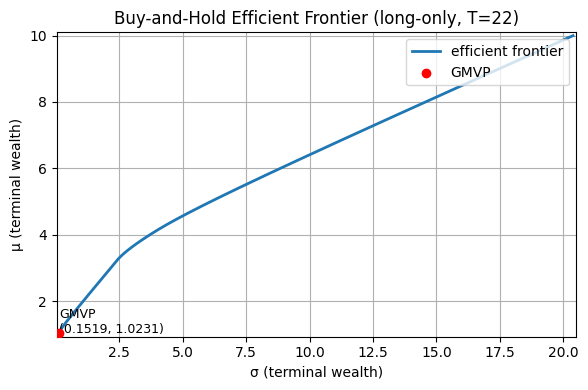

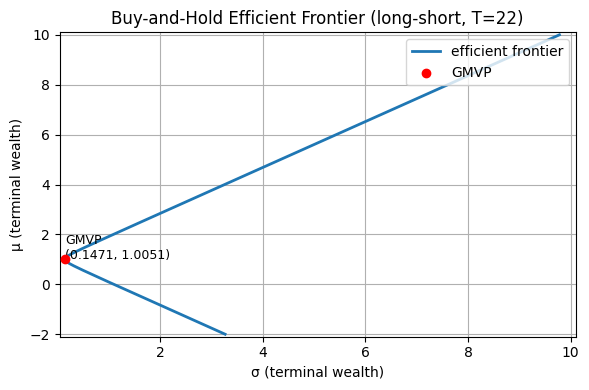

In [9]:
solver = solvebh
x_longonly = []
y_longonly = []
x_longshort = []
y_longshort = []
for mu_p in tqdm(grid):
    sigma = solver(mu_p, False)
    if sigma is not None:
        x_longonly.append(sigma)
        y_longonly.append(mu_p)
    sigma = solver(mu_p, True)
    if sigma is not None:
        x_longshort.append(sigma)
        y_longshort.append(mu_p)
x_longonly = np.array(x_longonly)
y_longonly = np.array(y_longonly)
x_longshort = np.array(x_longshort)
y_longshort = np.array(y_longshort)
# --- plot --------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(x_longonly, y_longonly, lw=2)
plt.scatter(x_longonly[x_longonly.argmin()], y_longonly[x_longonly.argmin()], color='red', zorder=5)
plt.text(x_longonly[x_longonly.argmin()], y_longonly[y_longonly.argmin()], f'GMVP\n({x_longonly[x_longonly.argmin()]:.4f}, {y_longonly[y_longonly.argmin()]:.4f})', fontsize=9)
plt.xlabel("σ (terminal wealth)")
plt.ylabel("μ (terminal wealth)")
plt.title("Buy-and-Hold Efficient Frontier (long-only, T=22)")
plt.legend(["efficient frontier", "GMVP"], loc="upper right")
plt.grid(True)
plt.ylim(y_longonly.min()-0.1,y_longonly.max()+0.1)
plt.xlim(x_longonly.min()-0.1, x_longonly.max()+0.1)
plt.tight_layout()
plt.savefig("q1no_shorting.png", dpi=300)
plt.show()
# --- plot --------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(x_longshort, y_longshort, lw=2)
plt.scatter(x_longshort[x_longshort.argmin()], y_longshort[x_longshort.argmin()], color='red', zorder=5)
plt.text(x_longshort[x_longshort.argmin()], y_longshort[x_longshort.argmin()], f'GMVP\n({x_longshort[x_longshort.argmin()]:.4f}, {y_longshort[x_longshort.argmin()]:.4f})', fontsize=9)
plt.xlabel("σ (terminal wealth)")
plt.ylabel("μ (terminal wealth)")
plt.title("Buy-and-Hold Efficient Frontier (long-short, T=22)")
plt.legend(["efficient frontier", "GMVP"], loc="upper right")
plt.grid(True)
plt.ylim(y_longshort.min()-0.1, y_longshort.max()+0.1)
plt.xlim(x_longshort.min()-0.1, y_longshort.max()+0.1)
plt.tight_layout()
plt.savefig("q1shorting.png", dpi=300)
plt.show()

#### Q2.

100%|██████████| 10000/10000 [00:44<00:00, 226.40it/s]


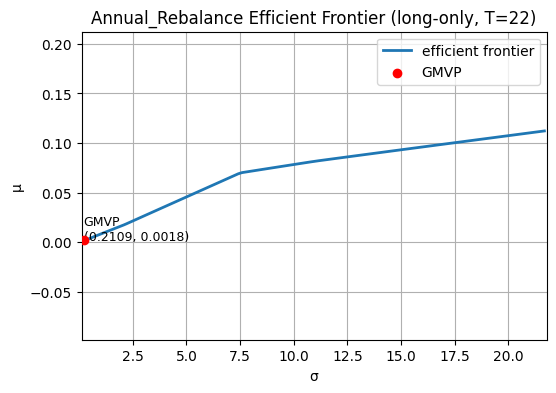

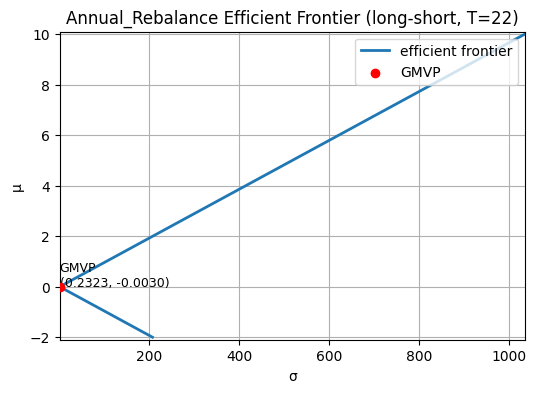

In [10]:
solver = solverb
x_longonly = []
y_longonly = []
x_longshort = []
y_longshort = []
for mu_p in tqdm(grid):
    sigma = solver(mu_p, False)
    if sigma is not None:
        x_longonly.append(sigma)
        y_longonly.append(mu_p)
    sigma = solver(mu_p, True)
    if sigma is not None:
        x_longshort.append(sigma)
        y_longshort.append(mu_p)
x_longonly = np.array(x_longonly)
y_longonly = np.array(y_longonly)
x_longshort = np.array(x_longshort)
y_longshort = np.array(y_longshort)
# --- plot --------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(x_longonly, y_longonly, lw=2)
plt.scatter(x_longonly[x_longonly.argmin()], y_longonly[x_longonly.argmin()], color='red', zorder=5)
plt.text(x_longonly[x_longonly.argmin()], y_longonly[y_longonly.argmin()], f'GMVP\n({x_longonly[x_longonly.argmin()]:.4f}, {y_longonly[y_longonly.argmin()]:.4f})', fontsize=9)
plt.xlabel("σ")
plt.ylabel("μ")
plt.title("Annual_Rebalance Efficient Frontier (long-only, T=22)")
plt.legend(["efficient frontier", "GMVP"], loc="upper right")
plt.grid(True)
plt.ylim(y_longonly.min()-0.1,y_longonly.max()+0.1)
plt.xlim(x_longonly.min()-0.1, x_longonly.max()+0.1)
plt.savefig("q2no_shorting.png", dpi=300)
plt.show()
# --- plot --------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(x_longshort, y_longshort, lw=2)
plt.scatter(x_longshort[x_longshort.argmin()], y_longshort[x_longshort.argmin()], color='red', zorder=5)
plt.text(x_longshort[x_longshort.argmin()], y_longshort[x_longshort.argmin()], f'GMVP\n({x_longshort[x_longshort.argmin()]:.4f}, {y_longshort[x_longshort.argmin()]:.4f})', fontsize=9)
plt.xlabel("σ")
plt.ylabel("μ")
plt.title("Annual_Rebalance Efficient Frontier (long-short, T=22)")
plt.legend(["efficient frontier", "GMVP"], loc="upper right")
plt.grid(True)
plt.ylim(y_longshort.min()-0.1, y_longshort.max()+0.1)
plt.xlim(x_longshort.min()-0.1, x_longshort.max()+0.1)
plt.savefig("q2shorting.png", dpi=300)
plt.show()

#### Q3.

100%|██████████| 10000/10000 [00:44<00:00, 222.56it/s]


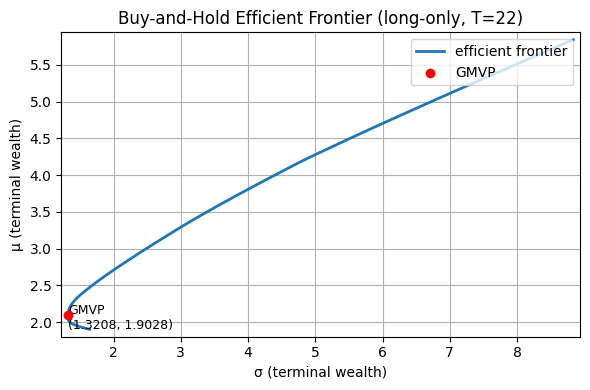

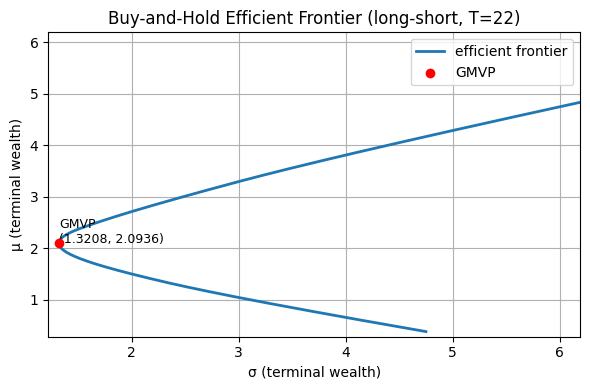

In [11]:
solver = solve3_bh
x_longonly = []
y_longonly = []
x_longshort = []
y_longshort = []
for mu_p in tqdm(grid):
    sigma = solver(mu_p, False)
    if sigma is not None:
        x_longonly.append(sigma)
        y_longonly.append(mu_p)
    sigma = solver(mu_p, True)
    if sigma is not None:
        x_longshort.append(sigma)
        y_longshort.append(mu_p)
x_longonly = np.array(x_longonly)
y_longonly = np.array(y_longonly)
x_longshort = np.array(x_longshort)
y_longshort = np.array(y_longshort)
# --- plot --------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(x_longonly, y_longonly, lw=2)
plt.scatter(x_longonly[x_longonly.argmin()], y_longonly[x_longonly.argmin()], color='red', zorder=5)
plt.text(x_longonly[x_longonly.argmin()], y_longonly[y_longonly.argmin()], f'GMVP\n({x_longonly[x_longonly.argmin()]:.4f}, {y_longonly[y_longonly.argmin()]:.4f})', fontsize=9)
plt.xlabel("σ (terminal wealth)")
plt.ylabel("μ (terminal wealth)")
plt.title("Buy-and-Hold Efficient Frontier (long-only, T=22)")
plt.legend(["efficient frontier", "GMVP"], loc="upper right")
plt.grid(True)
plt.ylim(y_longonly.min()-0.1,y_longonly.max()+0.1)
plt.xlim(x_longonly.min()-0.1, x_longonly.max()+0.1)
plt.tight_layout()
plt.savefig("q3_bhno_shorting.png", dpi=300)
plt.show()
# --- plot --------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(x_longshort, y_longshort, lw=2)
plt.scatter(x_longshort[x_longshort.argmin()], y_longshort[x_longshort.argmin()], color='red', zorder=5)
plt.text(x_longshort[x_longshort.argmin()], y_longshort[x_longshort.argmin()], f'GMVP\n({x_longshort[x_longshort.argmin()]:.4f}, {y_longshort[x_longshort.argmin()]:.4f})', fontsize=9)
plt.xlabel("σ (terminal wealth)")
plt.ylabel("μ (terminal wealth)")
plt.title("Buy-and-Hold Efficient Frontier (long-short, T=22)")
plt.legend(["efficient frontier", "GMVP"], loc="upper right")
plt.grid(True)
plt.ylim(y_longshort.min()-0.1, y_longshort.max()+0.1)
plt.xlim(x_longshort.min()-0.1, y_longshort.max()+0.1)
plt.tight_layout()
plt.savefig("q3_bh_shorting.png", dpi=300)
plt.show()

100%|██████████| 10000/10000 [00:45<00:00, 217.73it/s]


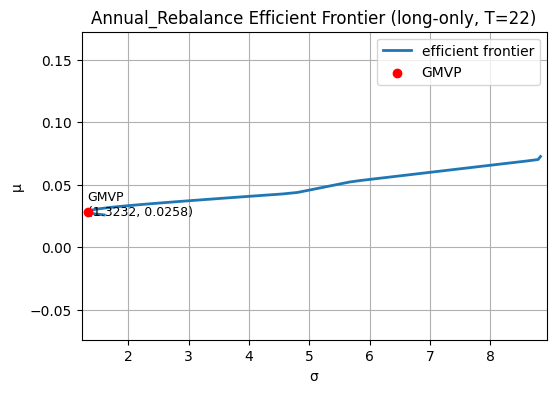

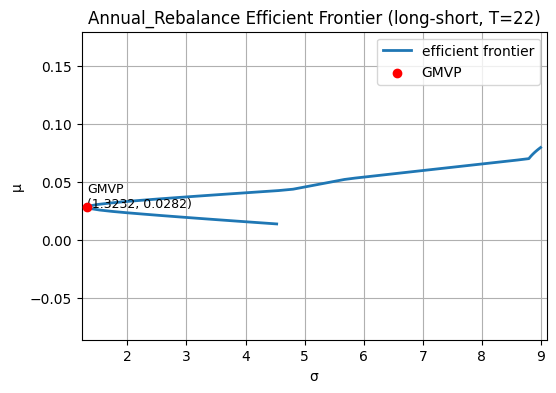

In [12]:
solver = solve3_rb
x_longonly = []
y_longonly = []
x_longshort = []
y_longshort = []
for mu_p in tqdm(grid):
    sigma = solver(mu_p, False)
    if sigma is not None:
        x_longonly.append(sigma)
        y_longonly.append(mu_p)
    sigma = solver(mu_p, True)
    if sigma is not None:
        x_longshort.append(sigma)
        y_longshort.append(mu_p)
x_longonly = np.array(x_longonly)
y_longonly = np.array(y_longonly)
x_longshort = np.array(x_longshort)
y_longshort = np.array(y_longshort)
# --- plot --------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(x_longonly, y_longonly, lw=2)
plt.scatter(x_longonly[x_longonly.argmin()], y_longonly[x_longonly.argmin()], color='red', zorder=5)
plt.text(x_longonly[x_longonly.argmin()], y_longonly[y_longonly.argmin()], f'GMVP\n({x_longonly[x_longonly.argmin()]:.4f}, {y_longonly[y_longonly.argmin()]:.4f})', fontsize=9)
plt.xlabel("σ")
plt.ylabel("μ")
plt.title("Annual_Rebalance Efficient Frontier (long-only, T=22)")
plt.legend(["efficient frontier", "GMVP"], loc="upper right")
plt.grid(True)
plt.ylim(y_longonly.min()-0.1,y_longonly.max()+0.1)
plt.xlim(x_longonly.min()-0.1, x_longonly.max()+0.1)
plt.savefig("q3rb_no_shorting.png", dpi=300)
plt.show()
# --- plot --------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(x_longshort, y_longshort, lw=2)
plt.scatter(x_longshort[x_longshort.argmin()], y_longshort[x_longshort.argmin()], color='red', zorder=5)
plt.text(x_longshort[x_longshort.argmin()], y_longshort[x_longshort.argmin()], f'GMVP\n({x_longshort[x_longshort.argmin()]:.4f}, {y_longshort[x_longshort.argmin()]:.4f})', fontsize=9)
plt.xlabel("σ")
plt.ylabel("μ")
plt.title("Annual_Rebalance Efficient Frontier (long-short, T=22)")
plt.legend(["efficient frontier", "GMVP"], loc="upper right")
plt.grid(True)
plt.ylim(y_longshort.min()-0.1, y_longshort.max()+0.1)
plt.xlim(x_longshort.min()-0.1, x_longshort.max()+0.1)
plt.savefig("q3rb_shorting.png", dpi=300)
plt.show()

### Q4.

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import invwishart, multivariate_normal, norm
from numba import njit, prange

start, end = "1990-12-31", "2025-01-01"
tickers = ["^SP500TR", "VBMFX", "^SPGSCI", "^IRX"]
px = yf.download(tickers, start=start, end=end, interval="1mo")["Close"]

irx_yld = px["^IRX"].ffill() / 100
rf_tr   = (1 + irx_yld/12).cumprod()
rf_tr.name = "RF"

lvl = pd.concat([px[["^SP500TR", "VBMFX", "^SPGSCI"]], rf_tr], axis=1)
lvl.columns = ["EQ", "BD", "CM", "RF"]
lvl = lvl.ffill().dropna()

ret_m = np.log(lvl).diff().loc["1991-01":"2012-12"].dropna()
ret_y = ret_m.resample("A").sum().pipe(np.exp).sub(1)
DATA  = ret_y.values                          # (22, 4)

def make_lambda0(mu0, coverage=0.90, rho=None):
    z_lower = norm.ppf(1 - coverage)
    tau = (1 + mu0) / abs(z_lower)
    tau[3] = 1e-3
    sigma = np.diag(tau)
    return mu0, sigma @ rho @ sigma

mu0, Lambda0 = make_lambda0(
    np.zeros(4),
    coverage=0.90,
    rho=np.array([[ 1, -0.3,  0.3, 0],
                  [-0.3,  1, -0.3, 0],
                  [ 0.3, -0.3,  1 ,0],
                  [ 0  ,  0 ,  0 ,1]])
)
nu0, S0 = 6, Lambda0.copy()

def gibbs_draws(data, n_draws, mu0, Lam0, nu0, S0):
    T, p = data.shape
    mu_out   = np.empty((n_draws, p))
    Sig_out  = np.empty((n_draws, p, p))

    mu, Sig = data.mean(0), np.cov(data.T)
    Lam0_inv, xbar = np.linalg.inv(Lam0), data.mean(0)

    for s in range(n_draws):
        Lam_T = np.linalg.inv(Lam0_inv + T * np.linalg.inv(Sig))
        mu_T  = Lam_T @ (Lam0_inv @ mu0 + T * np.linalg.inv(Sig) @ xbar)
        mu    = multivariate_normal(mu_T, Lam_T).rvs()
        Sig   = invwishart.rvs(df=nu0 + T,
                               scale=S0 + (data - mu).T @ (data - mu))

        mu_out[s]  = mu
        Sig_out[s] = Sig
    return mu_out, Sig_out

N_DRAW = 50_000
mu_samps, Sigma_samps = gibbs_draws(DATA, N_DRAW, mu0, Lambda0, nu0, S0)

@njit(parallel=True, fastmath=True)
def simulate_paths(mu_arr, Sig_arr, T_Y=20):
    S, p = mu_arr.shape
    out  = np.empty((S, T_Y, p))
    for s in prange(S):
        L = np.linalg.cholesky(Sig_arr[s])
        for t in range(T_Y):
            z = np.random.normal(0.0, 1.0, p)
            out[s, t] = mu_arr[s] + L @ z
    return out

r_paths = simulate_paths(mu_samps, Sigma_samps)    # (50 000, 20, 4)

# ------------------------------------------------------------------
# 4.  Wealth kernels (Numba)  --------------------------------------
# ------------------------------------------------------------------
T_YEARS = 10
V0      = 0
salary0, g, save_rt = 25714, 1.03, 1
C_T = (save_rt * salary0 * g**np.arange(T_YEARS)).astype(np.float64)

@njit(fastmath=True)
def wealth_bh(w, r):
    p = w.size
    grow = np.ones(p)
    contrib = 0.0
    for t in range(T_YEARS-1, -1, -1):
        for j in range(p):
            grow[j] *= 1.0 + r[t, j]
        contrib += C_T[t] * np.dot(w, grow)
    return V0 * np.dot(w, grow) + contrib

@njit(fastmath=True)
def wealth_rb(w, r):
    grow, contrib = 1.0, 0.0
    for t in range(T_YEARS-1, -1, -1):
        grow *= 1.0 + np.dot(r[t], w)
        contrib += C_T[t] * grow
    return V0 * grow + contrib

@njit(parallel=True, fastmath=True)
def mc_prob_hit(weights, paths, rebalance, target):
    """
    For each weight vector w_i  →  P( terminal wealth > target )
    """
    M, S = weights.shape[0], paths.shape[0]
    out  = np.empty(M)
    for i in prange(M):
        w   = weights[i]
        cnt = 0
        for s in range(S):
            tw = wealth_rb(w, paths[s]) if rebalance else wealth_bh(w, paths[s])
            if tw > target:
                cnt += 1
        out[i] = cnt / S
    return out

bh_lo_w = np.ascontiguousarray(bh_longonly,        dtype=np.float64)
bh_ls_w = np.ascontiguousarray(bh_longshort,       dtype=np.float64)
rb_lo_w = np.ascontiguousarray(rb_longonly,        dtype=np.float64)
rb_ls_w = np.ascontiguousarray(rb_longshort,       dtype=np.float64)
c_bh_lo = np.ascontiguousarray(constrained_bh_longonly,  dtype=np.float64)
c_bh_ls = np.ascontiguousarray(constrained_bh_longshort, dtype=np.float64)
c_rb_lo = np.ascontiguousarray(constrained_rb_longonly,  dtype=np.float64)
c_rb_ls = np.ascontiguousarray(constrained_rb_longshort, dtype=np.float64)


# prosperity    = (sum(1.03**(15+t) for t in rang .e(1, 6))*160_000/5*0.8)
target_wealth = 116_991

strategies = [
    ("bh_longonly"       , bh_lo_w, False),
    ("bh_longshort"      , bh_ls_w, False),
    ("rb_longonly"       , rb_lo_w, True ),
    ("rb_longshort"      , rb_ls_w, True ),
    ("constr_bh_longonly", c_bh_lo, False),
    ("constr_bh_longshort", c_bh_ls, False),
    ("constr_rb_longonly", c_rb_lo, True ),
    ("constr_rb_longshort", c_rb_ls, True )
]

best_P, best_w = {}, {}

for name, W, reb in tqdm(strategies, desc="8 strategies"):
    probs = mc_prob_hit(W, r_paths, rebalance=reb, target=target_wealth)
    idx   = np.argmax(probs)
    best_P[name] = probs[idx]
    best_w[name] = W[idx]

print(f"\nTarget wealth : {target_wealth:,.0f} ₩\n")

for k in strategies:
    key = k[0]
    P   = best_P[key]
    w   = best_w[key]
    print(f"{key:22s}  P_max = {P:6.4f}   w* = {np.round(w,4)}")


[*********************100%***********************]  4 of 4 completed
8 strategies: 100%|██████████| 8/8 [00:55<00:00,  6.96s/it]


Target wealth : 116,991 ₩

bh_longonly             P_max = 1.0000   w* = [-0.000e+00 -0.000e+00  1.000e-04  9.999e-01]
bh_longshort            P_max = 1.0000   w* = [-0.0199 -0.0388 -0.002   1.0608]
rb_longonly             P_max = 1.0000   w* = [0.     0.     0.0071 0.9929]
rb_longshort            P_max = 1.0000   w* = [-0.0852 -0.1699 -0.0725  1.3276]
constr_bh_longonly      P_max = 1.0000   w* = [ 0.3465  0.2535 -0.      0.4   ]
constr_bh_longshort     P_max = 1.0000   w* = [ 0.226   0.3768 -0.0028  0.4   ]
constr_rb_longonly      P_max = 1.0000   w* = [0.1282 0.3489 0.1229 0.4   ]
constr_rb_longshort     P_max = 1.0000   w* = [0.1282 0.3489 0.1229 0.4   ]


In [16]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import invwishart, multivariate_normal, norm
from numba import njit, prange
from tqdm.auto import tqdm

start, end = "1990-12-31", "2025-01-01"
tickers = ["^SP500TR", "VBMFX", "^SPGSCI", "^IRX"]
px = yf.download(tickers, start=start, end=end, interval="1mo")["Close"]

irx_yld = px["^IRX"].ffill() / 100
rf_tr   = (1 + irx_yld/12).cumprod()
rf_tr.name = "RF"

lvl = pd.concat([px[["^SP500TR", "VBMFX", "^SPGSCI"]], rf_tr], axis=1)
lvl.columns = ["EQ", "BD", "CM", "RF"]
lvl = lvl.ffill().dropna()

ret_m = np.log(lvl).diff().loc["1991-01":"2012-12"].dropna()
ret_y = ret_m.resample("A").sum().pipe(np.exp).sub(1)
DATA  = ret_y.values                          # (22, 4)

def make_lambda0(mu0, coverage=0.90, rho=None):
    z_lower = norm.ppf(1 - coverage)
    tau = (1 + mu0) / abs(z_lower)
    tau[3] = 1e-3
    sigma = np.diag(tau)
    return mu0, sigma @ rho @ sigma

mu0, Lambda0 = make_lambda0(
    np.zeros(4),
    coverage=0.90,
    rho=np.array([[ 1, -0.3,  0.3, 0],
                  [-0.3,  1, -0.3, 0],
                  [ 0.3, -0.3,  1 ,0],
                  [ 0  ,  0 ,  0 ,1]])
)
nu0, S0 = 6, Lambda0.copy()

def gibbs_draws(data, n_draws, mu0, Lam0, nu0, S0):
    T, p = data.shape
    mu_out   = np.empty((n_draws, p))
    Sig_out  = np.empty((n_draws, p, p))

    mu, Sig = data.mean(0), np.cov(data.T)
    Lam0_inv, xbar = np.linalg.inv(Lam0), data.mean(0)

    for s in range(n_draws):
        Lam_T = np.linalg.inv(Lam0_inv + T * np.linalg.inv(Sig))
        mu_T  = Lam_T @ (Lam0_inv @ mu0 + T * np.linalg.inv(Sig) @ xbar)
        mu    = multivariate_normal(mu_T, Lam_T).rvs()
        Sig   = invwishart.rvs(df=nu0 + T,
                               scale=S0 + (data - mu).T @ (data - mu))

        mu_out[s]  = mu
        Sig_out[s] = Sig
    return mu_out, Sig_out

N_DRAW = 50_000
mu_samps, Sigma_samps = gibbs_draws(DATA, N_DRAW, mu0, Lambda0, nu0, S0)

T_YEARS = 10                  # retirement horizon (45→69)
@njit(parallel=True, fastmath=True)
def simulate_paths(mu_arr, Sig_arr, T_Y):
    S, p = mu_arr.shape
    out  = np.empty((S, T_Y, p))
    for s in prange(S):
        L = np.linalg.cholesky(Sig_arr[s])
        for t in range(T_Y):
            z = np.random.normal(0.0, 1.0, p)
            out[s, t] = mu_arr[s] + L @ z
    return out

r_paths = simulate_paths(mu_samps, Sigma_samps, T_YEARS)  # (50 000, 24, 4)

V0      = 0
salary0, g, save_rt = 25714, 1.03, 1
C_T = (save_rt * salary0 * g**np.arange(T_YEARS)).astype(np.float64)

@njit(fastmath=True)
def wealth_bh(w, r):
    p = w.size
    grow = np.ones(p)
    contrib = 0.0
    for t in range(T_YEARS-1, -1, -1):
        for j in range(p):
            grow[j] *= 1.0 + r[t, j]
        contrib += C_T[t] * np.dot(w, grow)
    return V0 * np.dot(w, grow) + contrib

@njit(fastmath=True)
def wealth_rb(w, r):
    grow, contrib = 1.0, 0.0
    for t in range(T_YEARS-1, -1, -1):
        grow *= 1.0 + np.dot(r[t], w)
        contrib += C_T[t] * grow
    return V0 * grow + contrib

@njit(fastmath=True)
def loss_dist_one(w, paths, rebalance):
    S = paths.shape[0]
    out = np.empty(S)
    for s in range(S):
        tw = wealth_rb(w, paths[s]) if rebalance else wealth_bh(w, paths[s])
        out[s] = -tw                          # loss = − wealth
    return out

def var_cvar_loss(loss_arr, alpha=0.95):
    VaR  = np.percentile(loss_arr, alpha*100)       # 95-pct loss
    CVaR = loss_arr[loss_arr >= VaR].mean()         # mean worst 5 %
    return VaR, CVaR

bh_lo_w = np.ascontiguousarray(bh_longonly,        dtype=np.float64)
bh_ls_w = np.ascontiguousarray(bh_longshort,       dtype=np.float64)
rb_lo_w = np.ascontiguousarray(rb_longonly,        dtype=np.float64)
rb_ls_w = np.ascontiguousarray(rb_longshort,       dtype=np.float64)
c_bh_lo = np.ascontiguousarray(constrained_bh_longonly,  dtype=np.float64)
c_bh_ls = np.ascontiguousarray(constrained_bh_longshort, dtype=np.float64)
c_rb_lo = np.ascontiguousarray(constrained_rb_longonly,  dtype=np.float64)
c_rb_ls = np.ascontiguousarray(constrained_rb_longshort, dtype=np.float64)

strategies = [
    ("bh_longonly"       , bh_lo_w, False),
    ("bh_longshort"      , bh_ls_w, False),
    ("rb_longonly"       , rb_lo_w, True ),
    ("rb_longshort"      , rb_ls_w, True ),
    ("constr_bh_longonly", c_bh_lo, False),
    ("constr_bh_longshort", c_bh_ls, False),
    ("constr_rb_longonly", c_rb_lo, True ),
    ("constr_rb_longshort", c_rb_ls, True )
]

best_w, best_VaR, best_CVaR = {}, {}, {}

for name, W, reb in tqdm(strategies, desc="8 strategies"):
    best_idx  = 0
    min_VaR   = np.inf

    for i in range(W.shape[0]):                # scan all weights
        L_vec = loss_dist_one(W[i], r_paths, rebalance=reb)
        VaR_i, _ = var_cvar_loss(L_vec, alpha=0.95)
        if VaR_i < min_VaR:
            min_VaR, best_idx = VaR_i, i       # keep lower VaR

    best_w[name]   = W[best_idx]
    best_VaR[name] = min_VaR
    # CVaR for that same weight
    L_star         = loss_dist_one(best_w[name], r_paths, rebalance=reb)
    _, CVaR_star   = var_cvar_loss(L_star, alpha=0.95)
    best_CVaR[name]= CVaR_star

print("\nLoss-based risk metrics (lower = safer)   α = 95 %\n")
hdr = f"{'Strategy':22s}  {'VaR₉₅%':>12s}   {'CVaR₉₅%':>12s}   w*"
print(hdr); print('-'*len(hdr))
for k, *_ in strategies:
    print(f"{k:22s}  {best_VaR[k]:12,.0f}   "
          f"{best_CVaR[k]:12,.0f}   {np.round(best_w[k],4)}")


[*********************100%***********************]  4 of 4 completed
8 strategies: 100%|██████████| 8/8 [04:08<00:00, 31.02s/it]


Loss-based risk metrics (lower = safer)   α = 95 %

Strategy                      VaR₉₅%        CVaR₉₅%   w*
--------------------------------------------------------
bh_longonly                 -270,501       -261,187   [0.017  0.0741 0.0069 0.902 ]
bh_longshort                -270,501       -261,187   [0.017  0.0741 0.0069 0.902 ]
rb_longonly                 -271,581       -260,047   [-0.      0.0697  0.0624  0.8679]
rb_longshort                -271,107       -259,341   [-0.0151  0.0702  0.0671  0.8778]
constr_bh_longonly          -249,168       -226,919   [0.159  0.4    0.0415 0.3995]
constr_bh_longshort         -249,168       -226,919   [0.159  0.4    0.0415 0.3995]
constr_rb_longonly          -252,133       -226,427   [0.091  0.3361 0.1729 0.4   ]
constr_rb_longshort         -252,133       -226,427   [0.091  0.3361 0.1729 0.4   ]
